# Tutorials - LiDAR Quickstart

## What you will learn

In this tutorial, you will learn:

* How to ingest a LAS file as 3D TileDB sparse array with [PDAL](https://pdal.io/)
* How to slice LiDAR data natively from a TileDB array
* How to visualize the sliced data.
* How to run SQL queries on LiDAR data directly from TileDB

We will use the well known [Autzen point cloud](https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true) dataset.

## Preparation

In TileDB Cloud, we maintain the latest changes to the PDAL TileDB plugin, but the latest release can also be installed from Conda with `conda install -c conda-forge pdal`

First we download the Autzen LAS file we will use as follows.

In [2]:
!wget https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true -O autzen.laz

--2021-08-26 15:59:09--  https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/PDAL/data/raw/master/workshop/autzen.laz [following]
--2021-08-26 15:59:09--  https://github.com/PDAL/data/raw/master/workshop/autzen.laz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PDAL/data/master/workshop/autzen.laz [following]
--2021-08-26 15:59:09--  https://media.githubusercontent.com/media/PDAL/data/master/workshop/autzen.laz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respo

Let's inspect this point cloud dataset with [PDAL](https://pdal.io/) (this operation takes a couple of minutes to complete).

In [3]:
!pdal info autzen.laz | jq .

{
  "file_size": 56350988,
  "filename": "autzen.laz",
  "now": "2021-08-26T16:00:08+0000",
  "pdal_version": "2.3.0 (git-version: Release)",
  "reader": "readers.las",
  "stats": {
    "bbox": {
      "EPSG:4326": {
        "bbox": {
          "maxx": -123.0619599,
          "maxy": 44.06278031,
          "maxz": 615.26,
          "minx": -123.0755422,
          "miny": 44.04971882,
          "minz": 406.14
        },
        "boundary": {
          "type": "Polygon",
          "coordinates": [
            [
              [
                -123.07498674355058,
                44.04971881880158,
                406.14
              ],
              [
                -123.07554222854617,
                44.062486228152146,
                406.14
              ],
              [
                -123.06251259699623,
                44.06278030701668,
                615.26
              ],
              [
                -123.0619599185324,
                44.050012834694726,
            

## LAS Ingestion into TileDB¶

We first set the array name and clean up its directory from a potentially previous run.

In [4]:
import tiledb

output_array = 'autzen_tiledb'

In [5]:
import json
import shutil

# clean up any previous runs
try:
    shutil.rmtree(output_array)
except:
    pass

We will now ingest the LAS file into a TileDB array using the following PDAL pipeline.

In [6]:
initial_pipeline = [
   {
      'type': 'readers.las',
      'filename': "autzen.laz"
   },
   {
       'type' : 'filters.stats'
   },
   {
      'type': 'writers.tiledb',
      'array_name': f"{output_array}",
      'chunk_size': 10000000
   }
]

with open('pipeline.json', 'w') as f:
    json.dump(initial_pipeline, f)

In [7]:
!pdal pipeline -i pipeline.json --nostream

Let's inspect the schema of the TileDB array we created. The array has 3 dimensions and 13 attributes. TileDB provides very fast slicing on the three dimensions. The non-empty domain is the tightest 3D bounding box that contains all points in the dataset.

In [8]:
%%time
with tiledb.open(output_array) as arr:
    print(f"Non-empty domain: {arr.nonempty_domain()}")
    print(arr.schema)

Non-empty domain: ((array(635577.79), array(639003.73)), (array(848882.15), array(853537.66)), (array(406.14), array(615.26)))
ArraySchema(
  domain=Domain(*[
    Dim(name='X', domain=(635576.79, 639004.73), tile='None', dtype='float64'),
    Dim(name='Y', domain=(848881.15, 853538.66), tile='None', dtype='float64'),
    Dim(name='Z', domain=(405.14, 616.26), tile='None', dtype='float64'),
  ]),
  attrs=[
    Attr(name='Intensity', dtype='uint16', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ])),
    Attr(name='ReturnNumber', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='NumberOfReturns', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='ScanDirectionFlag', dtype='uint8', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ])),
    Attr(name='EdgeOfFlightLine', dtype='uint8', var=False, nullable=False, filters=FilterList([Bzip2Filter(lev

## Slicing LiDAR data from TileDB
We next slice a region directly from the TileDB array, which is executed very fast. The result is stored directly in a pandas dataframe, using zero-copy techniques for performance.

In [9]:
%%time
with tiledb.open(output_array) as arr:
    df = arr.df[636800:637800, 851000:853000, 406.14:615.26]

df

CPU times: user 1.75 s, sys: 1.06 s, total: 2.81 s
Wall time: 1.43 s


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,636808.13,851000.61,431.53,32,1,1,0,0,1,4.0,124,7330,247568.704326,180,161,136
1,636806.26,851000.09,431.40,39,1,1,1,0,2,3.0,124,7329,247182.241645,182,165,142
2,636800.97,851003.21,431.53,75,1,1,1,0,2,3.0,124,7329,247182.203346,194,177,156
3,636806.85,851002.22,431.50,54,1,1,1,0,2,3.0,124,7329,247182.241655,180,161,136
4,636805.76,851001.28,431.46,37,1,1,1,0,2,5.0,122,7330,247568.716934,187,169,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311294,637373.74,851704.33,591.21,65,1,1,0,0,1,-6.0,124,7331,248289.032643,238,240,233
1311295,637379.07,851702.48,590.35,59,1,1,0,0,1,-6.0,124,7331,248289.070963,238,240,232
1311296,637376.44,851703.44,589.96,35,1,1,0,0,1,-6.0,122,7331,248289.051808,238,240,234
1311297,637381.58,851701.15,590.26,48,1,1,0,0,1,-6.0,122,7331,248289.090128,237,240,232


## Visualization
We can plot the sliced data with matplotlib.

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot(pts):
    rgbs = np.array(list(zip(pts['Red'], pts['Green'], pts['Blue']))) / 255.0

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.ticklabel_format(useOffset=False)

    ax.scatter(pts['X'], pts['Y'], pts['Z'], c=rgbs)

    ax.set_xlabel('x', fontsize=20, labelpad=20)
    ax.set_ylabel('y', fontsize=20, labelpad=35)
    ax.set_zlabel('z', fontsize=20, labelpad=25)
    ax.set_title('Autzen', fontsize=20, pad=20)
    ax.view_init(60, 96)
    ax.tick_params(axis='y', pad=20)
    ax.tick_params(axis='z', pad=10)
    plt.show()

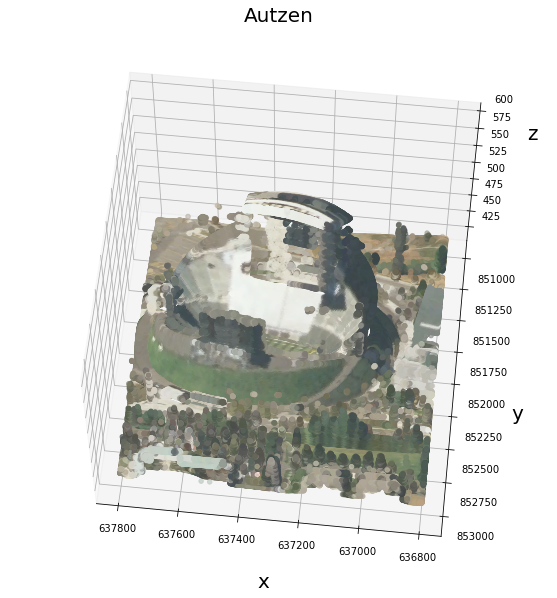

In [11]:
plot(df)

Alternatively, we can interactively visualize the data using [BabylonJS](https://www.babylonjs.com/).

In [12]:
import pybabylonjs

data = {
    'X': df['X'][::10],
    'Y': df['Y'][::10],
    'Z': df['Z'][::10],
    'Red': df['Red'][::10] / 255.0,
    'Green': df['Green'][::10] / 255.0,
    'Blue': df['Blue'][::10] / 255.0
}

In [13]:
babylon = pybabylonjs.BabylonJS()
babylon.value = data
babylon.z_scale = .2

In [14]:
# ctrl or right click - pan, wheel to zoom, left click to rotate
babylon

BabylonJS(extents=[636800.02, 637799.99, 851000.03, 852999.99, 415.55, 595.24], value='{"X": [636808.13, 63680…

## Running SQL on LiDAR data

TileDB supports any kind of SQL queries directly on the TileDB arrays via its integration with MariaDB. In the example below we calculate the number of rows returned by the slicing query we ran previously above.

In [15]:
%%time

import tiledb, tiledb.sql, pandas

db = tiledb.sql.connect()
res = pandas.read_sql(sql=
                f"""
                select COUNT(*) from `{output_array}` 
                WHERE X >= 636800 AND X <= 637800 AND
                      Y >= 851000 AND Y <= 853000 AND
                      Z >= 406.14 AND Z <= 615.26                      
                """
                , con=db)

res

CPU times: user 2.51 s, sys: 257 ms, total: 2.77 s
Wall time: 1.69 s


,COUNT(*)
0,1311299
